In [ ]:
import os

class CFG:
    project_name = "clarion-ai-003"
    
    compression_ratio = 0.9
    channels = 32
    
    batch_size = 8
    learning_rate = 0.001
    weight_decay = 1e-4
    epochs = 500
    wandb_api_key = os.environ.get("WANDB_API_KEY", "")
    dataset_path = "/input/speechocean762/train/*.wav"
    pretrained_model_path = "/input/clarion-ai-002-ds/speech_autoencoder.pth"
    model_save_path = "speech_autoencoder_en_score.pth"
    whisper_path = "openai/whisper-base"

preprocessor_config.json:   0%|          | 0.00/433 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/232 [00:00<?, ?B/s]

spm_char.model:   0%|          | 0.00/238k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/234 [00:00<?, ?B/s]

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/2.06k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/621M [00:00<?, ?B/s]

Some weights of SpeechT5ForSpeechToSpeech were not initialized from the model checkpoint at microsoft/speecht5_vc and are newly initialized: ['speecht5.encoder.prenet.pos_sinusoidal_embed.weights']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


config.json:   0%|          | 0.00/636 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/50.7M [00:00<?, ?B/s]

Original Audio:


Processed Audio:


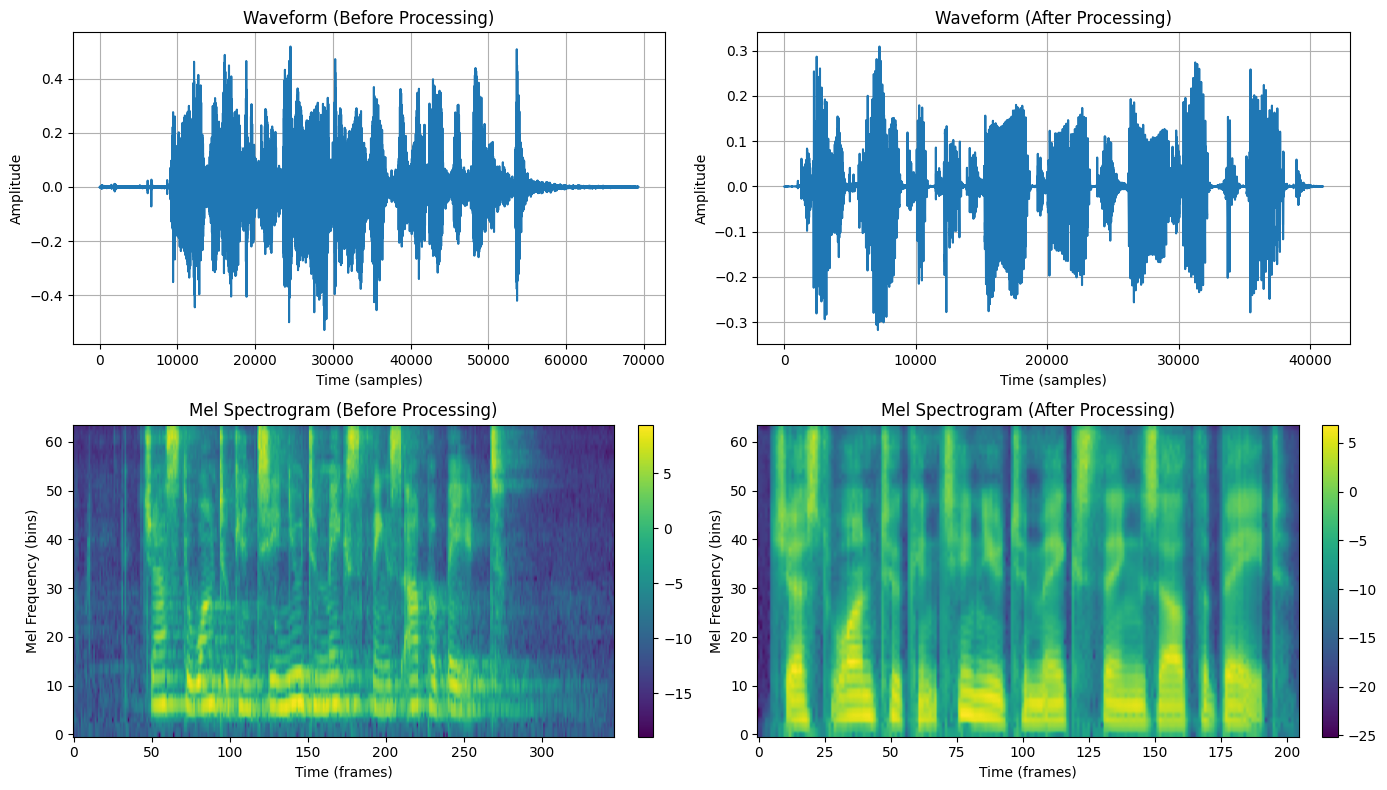

In [ ]:
import os
from glob import glob
from IPython.display import Audio, display
import torchaudio
import matplotlib.pyplot as plt
import torch
from transformers import SpeechT5Processor, SpeechT5ForSpeechToSpeech, SpeechT5HifiGan, set_seed


import os
from IPython.display import Audio, display
import torchaudio
import matplotlib.pyplot as plt

# Save audio to a file
def save_audio(waveform, sample_rate, file_name):
    torchaudio.save(file_name, waveform, sample_rate)


def plot_waveforms_and_spectrograms(waveform_before, waveform_after, sample_rate):
    output_dir = "tmp"
    os.makedirs(output_dir, exist_ok=True)

    # File names
    file_name_before = os.path.join(output_dir, "original.wav")
    file_name_after = os.path.join(output_dir, "processed.wav")

    # Save audio files
    torchaudio.save(file_name_before, waveform_before, sample_rate)
    torchaudio.save(file_name_after, waveform_after, sample_rate)

    # Display saved audio
    print("Original Audio:")
    display(Audio(file_name_before))
    print("Processed Audio:")
    display(Audio(file_name_after))

    # Compute Mel Spectrograms
    transform = torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=64)
    mel_spectrogram_before = transform(waveform_before)
    mel_spectrogram_after = transform(waveform_after)

    # Plot Waveforms and Spectrograms Side-by-Side
    fig, axes = plt.subplots(2, 2, figsize=(14, 8))

    # Waveform Before
    axes[0, 0].plot(waveform_before.t().numpy())
    axes[0, 0].set_title("Waveform (Before Processing)")
    axes[0, 0].set_xlabel("Time (samples)")
    axes[0, 0].set_ylabel("Amplitude")
    axes[0, 0].grid()

    # Waveform After
    axes[0, 1].plot(waveform_after.t().numpy())
    axes[0, 1].set_title("Waveform (After Processing)")
    axes[0, 1].set_xlabel("Time (samples)")
    axes[0, 1].set_ylabel("Amplitude")
    axes[0, 1].grid()

    # Spectrogram Before
    img_before = axes[1, 0].imshow(
        mel_spectrogram_before.log2()[0, :, :].numpy(),
        cmap='viridis',
        origin='lower',
        aspect='auto'
    )
    axes[1, 0].set_title("Mel Spectrogram (Before Processing)")
    axes[1, 0].set_xlabel("Time (frames)")
    axes[1, 0].set_ylabel("Mel Frequency (bins)")
    fig.colorbar(img_before, ax=axes[1, 0], orientation='vertical', fraction=0.046, pad=0.04)

    # Spectrogram After
    img_after = axes[1, 1].imshow(
        mel_spectrogram_after.log2()[0, :, :].numpy(),
        cmap='viridis',
        origin='lower',
        aspect='auto'
    )
    axes[1, 1].set_title("Mel Spectrogram (After Processing)")
    axes[1, 1].set_xlabel("Time (frames)")
    axes[1, 1].set_ylabel("Mel Frequency (bins)")
    fig.colorbar(img_after, ax=axes[1, 1], orientation='vertical', fraction=0.046, pad=0.04)

    # Adjust layout
    plt.tight_layout()
    plt.show()
    

# Main Script
if __name__ == "__main__":
    audio_files = glob("/input/speechocean762/train/*.wav")
    audio_file = audio_files[0]
    waveform_before, sample_rate = torchaudio.load(audio_file)
    
    # Load the processor, model, and vocoder
    processor = SpeechT5Processor.from_pretrained("microsoft/speecht5_vc")
    model = SpeechT5ForSpeechToSpeech.from_pretrained("microsoft/speecht5_vc")
    vocoder = SpeechT5HifiGan.from_pretrained("microsoft/speecht5_hifigan")
    
    # Prepare the input tensor
    inputs = processor(audio=waveform_before.squeeze().numpy(), sampling_rate=sample_rate, return_tensors="pt")
    speaker_embeddings = torch.zeros((1, 512))
    waveform_after = model.generate_speech(inputs["input_values"], speaker_embeddings, vocoder=vocoder)
    waveform_after = waveform_after.unsqueeze(0)

    # Plot waveforms and spectrograms
    plot_waveforms_and_spectrograms(waveform_before, waveform_after, sample_rate)